In [1]:
# CELL 0 — Imports & Options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

plt.rcParams["figure.figsize"] = (8,4)
pd.set_option("display.max_columns", 100)


In [2]:
# CELL 1 — Load data
PATH = r"C:\\Users\\HP\\Desktop\\a\\hospital_appointments.csv"  
df = pd.read_csv(PATH)
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# CELL 2 — Quick structure
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nNulls:\n", df.isna().sum())


Shape: (110527, 14)

Dtypes:
 PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

Nulls:
 PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


In [4]:
# CELL 3 — Understand target & basic columns
target_col = "No-show"  # 'Yes' or 'No'
print("Unique target values:", df[target_col].unique())
print("\nColumns:", list(df.columns))


Unique target values: ['No' 'Yes']

Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']


In [5]:
# CELL 4 — Identify categorical vs numeric (initial guess)
cat_cols_guess = ["Gender", "Neighbourhood", "SMS_received", "Scholarship",
                  "Hypertension", "Diabetes", "Alcoholism", "Handcap"]
num_cols_guess = ["Age"]  # waiting_days will be added later

print("Categorical (initial guess):", [c for c in cat_cols_guess if c in df.columns])
print("Numeric (initial guess):", [c for c in num_cols_guess if c in df.columns])


Categorical (initial guess): ['Gender', 'Neighbourhood', 'SMS_received', 'Scholarship', 'Diabetes', 'Alcoholism', 'Handcap']
Numeric (initial guess): ['Age']


In [6]:
# CELL 5 — Drop irrelevant IDs if present
for col in ["PatientId", "AppointmentID", "AppointmentId"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True, errors="ignore")

df.shape


(110527, 12)

In [7]:
# CELL 6 — Standardize column name variants
# Some forks have typos or different casing
rename_map = {
    "Neighbourhood": "Neighborhood",
    "Handcap": "Handicap",     # common typo in dataset
    "Hipertension": "Hypertension"  # rare variant
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)


In [8]:
# CELL 7 — Convert date columns to datetime
for c in ["ScheduledDay", "AppointmentDay"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df[["ScheduledDay","AppointmentDay"]].head()


,ScheduledDay,AppointmentDay
0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00
1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00
2,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00
3,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00
4,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00


In [9]:
# CELL 8 — Clean ages (0–100) and drop exact duplicates
if "Age" in df.columns:
    df = df[(df["Age"] >= 0) & (df["Age"] <= 100)].copy()

before = len(df)
df.drop_duplicates(inplace=True)
print("Removed duplicates:", before - len(df))


Removed duplicates: 634


In [10]:
# CELL 9 — Target as 0/1
df["NoShow"] = df["No-show"].map({"No":0, "Yes":1}).astype(int)
df["NoShow"].value_counts(normalize=True)


NoShow
0    0.798917
1    0.201083
Name: proportion, dtype: float64

In [11]:
# CELL 10 — Waiting time (days)
df["waiting_days"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days
df["waiting_days"].describe()


count    109885.000000
mean          9.158011
std          15.251588
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: waiting_days, dtype: float64

In [12]:
# CELL 11 — Day of week & weekend flag
df["appointment_dow"] = df["AppointmentDay"].dt.day_name()
df["appointment_dow_num"] = df["AppointmentDay"].dt.dayofweek  # Mon=0
df["is_weekend"] = df["appointment_dow_num"].isin([5,6]).astype(int)
df[["appointment_dow","appointment_dow_num","is_weekend"]].head()


,appointment_dow,appointment_dow_num,is_weekend
0,Friday,4,0
1,Friday,4,0
2,Friday,4,0
3,Friday,4,0
4,Friday,4,0


In [14]:
# CELL 12 — Age groups
bins = [0, 12, 18, 35, 50, 65, 100]
labels = ["child","teen","young_adult","adult","middle_age","senior"]
df["age_group"] = pd.cut(df["Age"], bins=bins, labels=labels, include_lowest=True)
df["age_group"].value_counts()


age_group
young_adult    23967
middle_age     21992
adult          21965
child          20948
senior         13242
teen            7771
Name: count, dtype: int64

In [15]:
# CELL 13 — Neighborhood risk score (historical no-show rate)
if "Neighborhood" in df.columns:
    neigh_rate = df.groupby("Neighborhood")["NoShow"].mean().rename("neighborhood_noshow_rate")
    df = df.merge(neigh_rate, on="Neighborhood", how="left")
else:
    df["neighborhood_noshow_rate"] = df["NoShow"].mean()
df[["Neighborhood","neighborhood_noshow_rate"]].head()


,Neighborhood,neighborhood_noshow_rate
0,JARDIM DA PENHA,0.162923
1,JARDIM DA PENHA,0.162923
2,MATA DA PRAIA,0.169518
3,PONTAL DE CAMBURI,0.173913
4,JARDIM DA PENHA,0.162923


In [16]:
# CELL 14 — Interaction feature: SMS * waiting_days
if "SMS_received" not in df.columns:
    df["SMS_received"] = 0
df["sms_x_wait"] = df["SMS_received"] * df["waiting_days"]
df[["SMS_received","waiting_days","sms_x_wait"]].head()


,SMS_received,waiting_days,sms_x_wait
0,0,-1,0
1,0,-1,0
2,0,-1,0
3,0,-1,0
4,0,-1,0


In [17]:
# CELL 15 — Final feature list (we’ll one-hot some later)
feature_cols = [
    "Gender", "Age", "Scholarship", "Hypertension", "Diabetes",
    "Alcoholism", "Handicap", "SMS_received", "waiting_days",
    "Neighborhood", "appointment_dow", "appointment_dow_num",
    "is_weekend", "age_group", "neighborhood_noshow_rate", "sms_x_wait"
]
feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)


Using features: ['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'waiting_days', 'Neighborhood', 'appointment_dow', 'appointment_dow_num', 'is_weekend', 'age_group', 'neighborhood_noshow_rate', 'sms_x_wait']


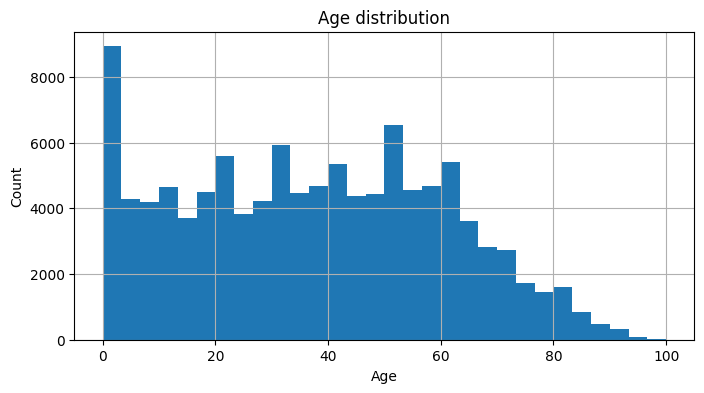

In [18]:
# CELL 16 — Basic distributions
df["Age"].hist(bins=30)
plt.title("Age distribution")
plt.xlabel("Age"); plt.ylabel("Count")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_17524\4116972477.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(col)["NoShow"].mean().sort_values(ascending=False)


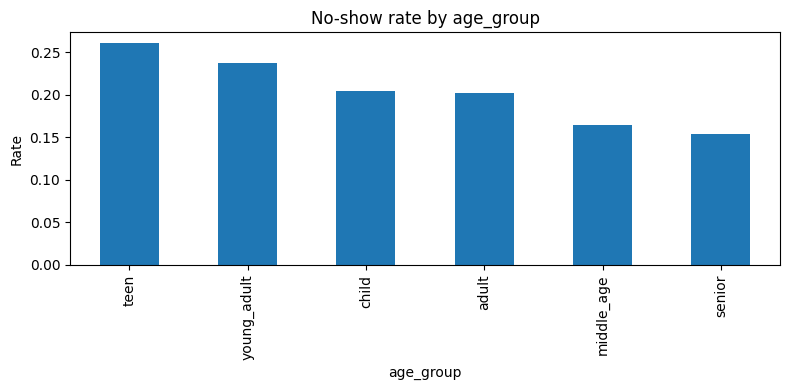

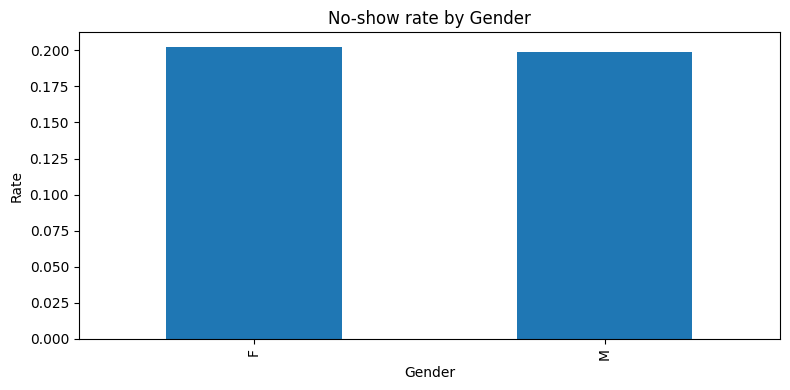

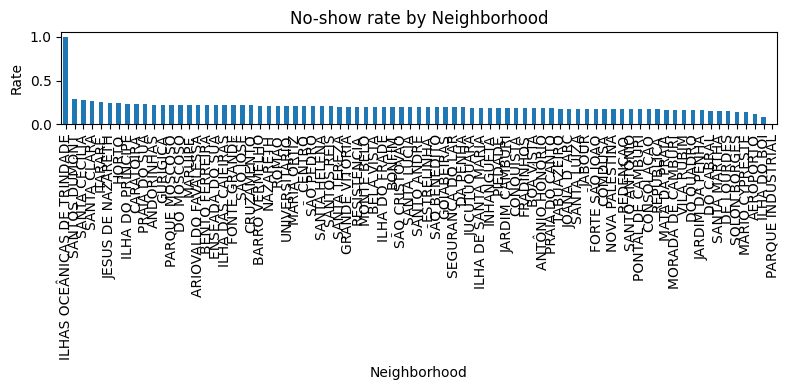

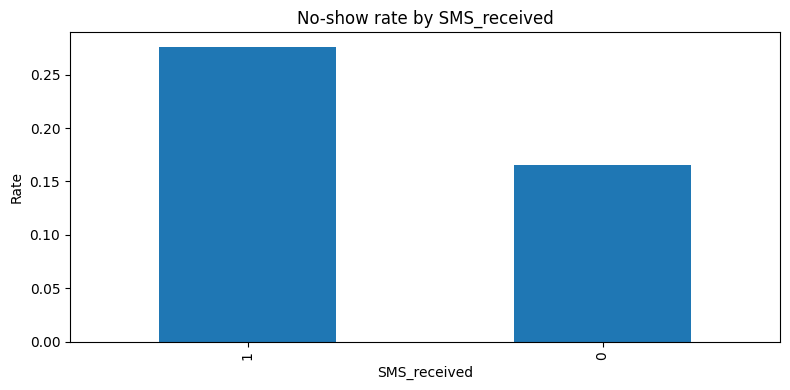

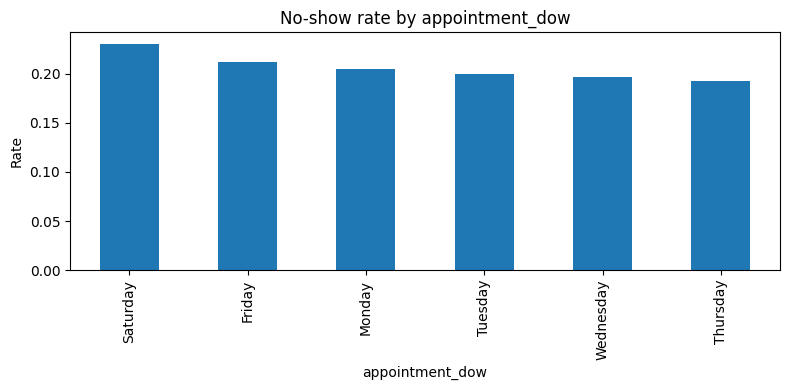

In [19]:
# CELL 17 — No-show rate by category helper
def rate_by(col):
    grp = df.groupby(col)["NoShow"].mean().sort_values(ascending=False)
    ax = grp.plot(kind="bar")
    ax.set_title(f"No-show rate by {col}")
    ax.set_ylabel("Rate")
    plt.tight_layout(); plt.show()
    return grp

for c in ["age_group","Gender","Neighborhood","SMS_received","appointment_dow"]:
    if c in df.columns:
        _ = rate_by(c)


C:\Users\HP\AppData\Local\Temp\ipykernel_17524\4116972477.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(col)["NoShow"].mean().sort_values(ascending=False)


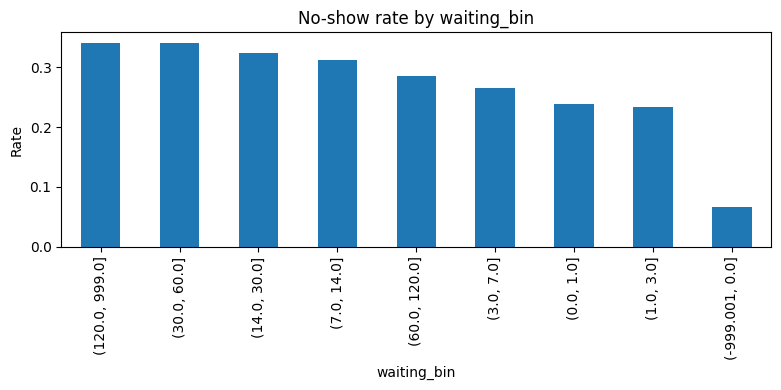

In [20]:
# CELL 18 — Waiting time vs no-show (binned)
df["waiting_bin"] = pd.cut(df["waiting_days"], bins=[-999,0,1,3,7,14,30,60,120,999], include_lowest=True)
_ = rate_by("waiting_bin")


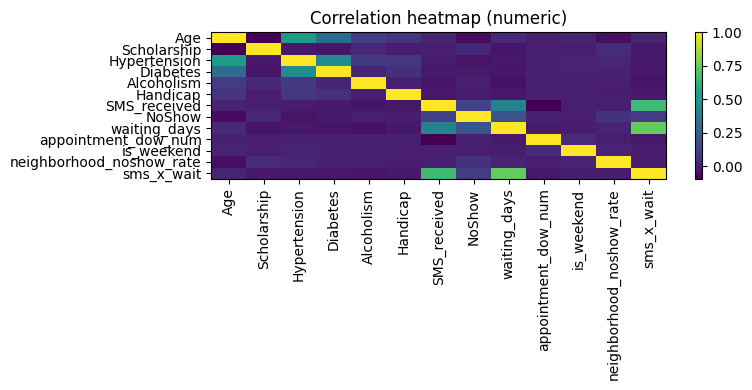

In [21]:
# CELL 19 — Correlation heatmap (numeric only)
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation heatmap (numeric)")
plt.tight_layout(); plt.show()


In [23]:
# CELL 21 — Split features/target
y = df["NoShow"].astype(int)
X = df[feature_cols].copy()

categorical = [c for c in ["Gender","Neighborhood","appointment_dow","age_group"] if c in X.columns]
numeric = [c for c in X.columns if c not in categorical]

print("Categorical:", categorical)
print("Numeric:", numeric)


Categorical: ['Gender', 'Neighborhood', 'appointment_dow', 'age_group']
Numeric: ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'waiting_days', 'appointment_dow_num', 'is_weekend', 'neighborhood_noshow_rate', 'sms_x_wait']


In [24]:
# CELL 22 — ColumnTransformer (OneHot + Scale)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((76919, 16), (32966, 16))

In [25]:
# CELL 23 — Class imbalance helpers (SMOTE optional + class weights)
# We'll prefer class weights (simple, built-in). If you want SMOTE, uncomment try-block.
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = {cls:w for cls,w in zip(classes, weights)}
class_weight


{np.int64(0): np.float64(0.625846188895398),
 np.int64(1): np.float64(2.486552013965216)}

In [31]:
# # CELL 24 — (Optional) SMOTE
# #use_smote = False
# try:
#     from imblearn.over_sampling import SMOTE
#     from imblearn.pipeline import Pipeline as ImbPipeline
#     use_smote = True
#     print("SMOTE available. You can enable it in modeling cells for LR/MLP.")
# except Exception as e:
#     print("SMOTE not available; proceeding without it.")


SMOTE not available; proceeding without it.


In [32]:
# CELL 25 — Decision Tree baseline
dt = DecisionTreeClassifier(max_depth=6, random_state=42, class_weight=class_weight)

dt_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", dt)
])

dt_pipe.fit(X_train, y_train)
y_pred = dt_pipe.predict(X_test)
y_proba = dt_pipe.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.571376569799187
Precision: 0.3002609575544549
Recall: 0.8505053552572032
F1: 0.4438321656301661
ROC-AUC: 0.7284669259548594

Confusion Matrix:
 [[13198 13139]
 [  991  5638]]


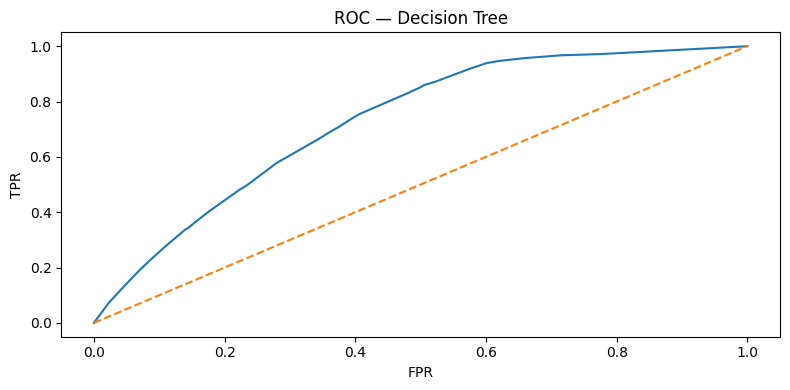

In [33]:
# CELL 26 — ROC curve (Decision Tree)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC — Decision Tree")
plt.tight_layout(); plt.show()



In [34]:
# CELL 27 — Random Forest
rf = RandomForestClassifier(
    n_estimators=300, random_state=42, n_jobs=-1, class_weight=class_weight
)
rf_pipe = Pipeline([("prep", preprocess), ("clf", rf)])
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)
rf_proba = rf_pipe.predict_proba(X_test)[:,1]

print("RF — Acc:", accuracy_score(y_test, rf_pred), 
      "F1:", f1_score(y_test, rf_pred), 
      "AUC:", roc_auc_score(y_test, rf_proba))


RF — Acc: 0.771340168658618 F1: 0.2593829829043034 AUC: 0.7114103386720688


In [35]:
# CELL 28 — Logistic Regression (with optional SMOTE)
logreg = LogisticRegression(max_iter=300, solver="saga", class_weight=class_weight, n_jobs=None)

if use_smote:
    lr_pipe = ImbPipeline([("prep", preprocess), ("smote", SMOTE(random_state=42)), ("clf", logreg)])
else:
    lr_pipe = Pipeline([("prep", preprocess), ("clf", logreg)])

lr_pipe.fit(X_train, y_train)
lr_pred = lr_pipe.predict(X_test)
lr_proba = lr_pipe.predict_proba(X_test)[:,1]

print("LogReg — Acc:", accuracy_score(y_test, lr_pred), 
      "F1:", f1_score(y_test, lr_pred), 
      "AUC:", roc_auc_score(y_test, lr_proba))


D:\anoconda\envs\newenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg — Acc: 0.6426621367469514 F1: 0.42113022113022114 AUC: 0.6887999152152365


In [36]:
# CELL 29 — MLP (simple)
mlp = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42, max_iter=200)

if use_smote:
    mlp_pipe = ImbPipeline([("prep", preprocess), ("smote", SMOTE(random_state=42)), ("clf", mlp)])
else:
    mlp_pipe = Pipeline([("prep", preprocess), ("clf", mlp)])

mlp_pipe.fit(X_train, y_train)
mlp_pred = mlp_pipe.predict(X_test)
mlp_proba = mlp_pipe.predict_proba(X_test)[:,1]

print("MLP — Acc:", accuracy_score(y_test, mlp_pred), 
      "F1:", f1_score(y_test, mlp_pred), 
      "AUC:", roc_auc_score(y_test, mlp_proba))


D:\anoconda\envs\newenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP — Acc: 0.768306740277862 F1: 0.27215551743853633 AUC: 0.6968602241575941


In [37]:
# CELL 30 — (Optional) XGBoost / CatBoost — will auto-skip if not installed
scores = []

try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=5, subsample=0.9,
        colsample_bytree=0.9, random_state=42, eval_metric="logloss", tree_method="hist"
    )
    xgb_pipe = Pipeline([("prep", preprocess), ("clf", xgb)])
    xgb_pipe.fit(X_train, y_train)
    xgb_pred = xgb_pipe.predict(X_test)
    xgb_proba = xgb_pipe.predict_proba(X_test)[:,1]
    scores.append(("XGBoost", roc_auc_score(y_test, xgb_proba)))
    print("XGBoost — AUC:", roc_auc_score(y_test, xgb_proba))
except Exception as e:
    print("XGBoost not available/failed:", e)

try:
    from catboost import CatBoostClassifier
    cb = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, verbose=False, random_seed=42)
    cb_pipe = Pipeline([("prep", preprocess), ("clf", cb)])
    cb_pipe.fit(X_train, y_train)
    cb_pred = cb_pipe.predict(X_test)
    cb_proba = cb_pipe.predict_proba(X_test)[:,1]
    scores.append(("CatBoost", roc_auc_score(y_test, cb_proba)))
    print("CatBoost — AUC:", roc_auc_score(y_test, cb_proba))
except Exception as e:
    print("CatBoost not available/failed:", e)

print("\nModel AUC summary (incl. DT/RF/LR/MLP):")
summary = [
    ("DecisionTree", roc_auc_score(y_test, y_proba)),
    ("RandomForest", roc_auc_score(y_test, rf_proba)),
    ("LogReg", roc_auc_score(y_test, lr_proba)),
    ("MLP", roc_auc_score(y_test, mlp_proba))
] + scores
for name, auc in summary:
    print(f"{name:>14}: {auc:.3f}")


XGBoost not available/failed: No module named 'xgboost'
CatBoost not available/failed: No module named 'catboost'

Model AUC summary (incl. DT/RF/LR/MLP):
  DecisionTree: 0.728
  RandomForest: 0.711
        LogReg: 0.689
           MLP: 0.697


In [38]:
# CELL 31 — Choose a model to interpret (use RF if available; else DT)
best_pipe = rf_pipe if 'rf_pipe' in globals() else dt_pipe
chosen = "RandomForest" if 'rf_pipe' in globals() else "DecisionTree"
print("Chosen for interpretation:", chosen)


Chosen for interpretation: RandomForest


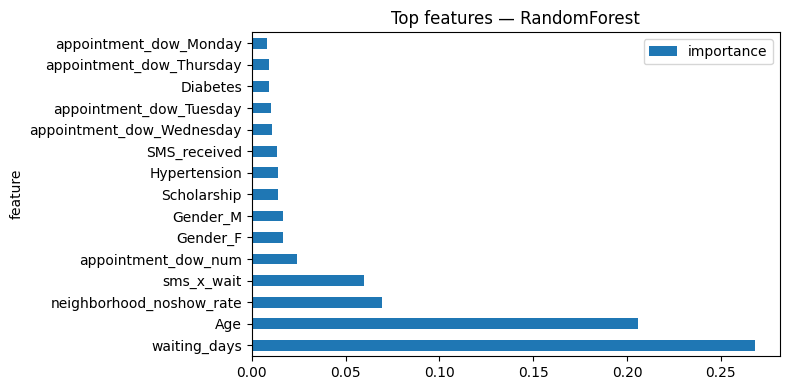

In [39]:
# CELL 32 — Feature importances (tree-based)
def get_feature_names(preprocess, categorical, numeric):
    # OneHot feature names
    ohe = preprocess.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(categorical)) if hasattr(ohe, "get_feature_names_out") else categorical
    return cat_names + numeric

feat_names = get_feature_names(preprocess, categorical, numeric)

importances = getattr(best_pipe.named_steps["clf"], "feature_importances_", None)
if importances is not None and len(importances) == len(feat_names):
    imp = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False).head(15)
    imp.plot(kind="barh", x="feature", y="importance")
    plt.title(f"Top features — {chosen}")
    plt.tight_layout(); plt.show()
else:
    print("Model does not expose feature_importances_.")
